How much does an offset in $\phi$ between photometry (SGA) and kinematics affect our measure of the rotational velocity?

In [1]:
import numpy as np

from astropy.table import Table
import astropy.constants as const
import astropy.units as u

import os

# Path to RotationCurve libraries. Update as needed.
#rotcurvepath = os.path.join(os.environ['HOME'], 'desi/RotationCurves/spirals')
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
if not os.path.exists(rotcurvepath):
    raise FileNotFoundError(f'{rotcurvepath} does not exist.')

import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=12)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Import data

## SGA

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## SDSS MaNGA best-fits

From Douglass & Demina (2022)

In [6]:
MaNGA_fits = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_H2_noWords_v8.txt', 
                        format='ascii.commented_header')

In [7]:
MaNGA_dict = {}

for i in range(len(MaNGA_fits)):
    
    plateifu = str(MaNGA_fits['MaNGA_plate'][i]) + '-' + str(MaNGA_fits['MaNGA_IFU'][i])
    
    MaNGA_dict[plateifu] = i

## SDSS MaNGA cross-match file

Made by Grace Chiodo in Summer 2021, using SDSS MaNGA DR15.

In [8]:
SGA_MaNGA = Table.read('MaNGA_DESI_galaxies_08042021.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu
int64,int64,int64,float64,float64,str10
7968,3702,97758,0.3215293288230896,159.22218322753906,7968-3702
8479,6101,433955,0.32715362310409546,54.33457565307617,8479-6101
8479,6102,487085,0.5813088417053223,1.3182913064956665,8479-6102
8480,6103,487085,0.5813088417053223,1.3182913064956665,8480-6103
8481,12705,810971,0.268082857131958,56.5462760925293,8481-12705


### Add the NSA redshift, $\phi$, $V_\text{max}$, $R_\text{turn}$, and $\alpha$ from the MaNGA fits

In [9]:
SGA_MaNGA['z_NSA'] = np.nan
SGA_MaNGA['phi_map'] = np.nan
SGA_MaNGA['phi_err_map'] = np.nan
SGA_MaNGA['Vmax'] = np.nan
SGA_MaNGA['Vmax_err'] = np.nan
SGA_MaNGA['Rturn'] = np.nan
SGA_MaNGA['Rturn_err'] = np.nan
SGA_MaNGA['alpha'] = np.nan
SGA_MaNGA['alpha_err'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    plateifu = str(SGA_MaNGA['MaNGA_plate'][i]) + '-' + str(SGA_MaNGA['MaNGA_IFU'][i])
    
    # These objects were checked via visual inspection and found to not be spiral galaxies
    if plateifu not in ['8932-3703', '8950-3702', '8931-3702', '8932-12705', '9876-6102', '8950-9102', '8931-1902', '8949-12705', '8932-12702', '8932-6102', '8935-9101', '8934-1901', '8949-3704']:
        
        i_MaNGA = MaNGA_dict[plateifu]
        
        SGA_MaNGA['z_NSA'][i] = MaNGA_fits['NSA_redshift'][i_MaNGA]
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_MaNGA]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_MaNGA]
        SGA_MaNGA['Vmax'][i] = MaNGA_fits['Vmax_map'][i_MaNGA]
        SGA_MaNGA['Vmax_err'][i] = MaNGA_fits['Vmax_err_map'][i_MaNGA]
        SGA_MaNGA['Rturn'][i] = MaNGA_fits['Rturn_map'][i_MaNGA]
        SGA_MaNGA['Rturn_err'][i] = MaNGA_fits['Rturn_err_map'][i_MaNGA]
        SGA_MaNGA['alpha'][i] = MaNGA_fits['alpha_map'][i_MaNGA]
        SGA_MaNGA['alpha_err'][i] = MaNGA_fits['alpha_err_map'][i_MaNGA]
    
SGA_MaNGA['phi_map'][SGA_MaNGA['phi_map'] < 0] = np.nan
SGA_MaNGA['phi_err_map'][SGA_MaNGA['phi_err_map'] < 0] = np.nan

### Add $R_{26}$, $\phi$, and $i$ from the SGA

In [10]:
SGA_MaNGA['R26'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    sgaid = SGA_MaNGA['sga_id'][i]
    
    i_SGA = SGA_dict[sgaid]
    
    SGA_MaNGA['R26'][i] = 0.5*SGA['D26'][i_SGA] # arcmin

# Compare $\phi$ from the SGA and the MaNGA fit

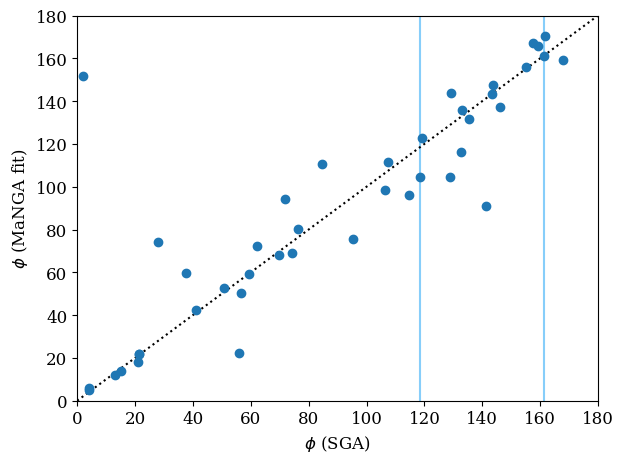

In [11]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['PA'], 
             SGA_MaNGA['phi_map']%180, 
             yerr=SGA_MaNGA['phi_err_map'],
             fmt='o', 
             ecolor='lightskyblue')

plt.plot([0, 180], [0, 180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.xlabel('$\phi$ (SGA)')
plt.ylabel('$\phi$ (MaNGA fit)');

# Compare the rotational velocities at 0.33$R_{26}$ from the best-fit to MaNGA if $\phi$ is from the SGA or from the MaNGA best fit

## 1) Convert $R_{26}$ to kpc for each galaxy

In [12]:
dist_to_galaxy = SGA_MaNGA['z_NSA']*c/H0

R26_kpc = dist_to_galaxy.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to('radian'))

## 2) Compute $R$ and $R'$

\begin{equation}
  R = 0.33R_{26}
\end{equation}

In [21]:
R = 0.33*R26_kpc

SGA_MaNGA['R'] = R

\begin{equation}
  R'^2 = \left( \frac{R\sin \Delta \phi}{\cos i} \right)^2 + (R\cos \Delta \phi)^2
\end{equation}

In [27]:
dphi = SGA_MaNGA['phi_map']%180 - SGA_MaNGA['PA']

dphi[dphi > 90] = 180 - dphi[dphi > 90]

SGA_MaNGA['delta_phi'] = dphi

cosi2 = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2[cosi2 < 0] = 0

Rp = np.sqrt(((R*np.sin(np.abs(dphi)))**2/cosi2) + (R*np.cos(np.abs(dphi)))**2)

SGA_MaNGA['cosi2'] = cosi2
SGA_MaNGA['R_prime'] = Rp

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


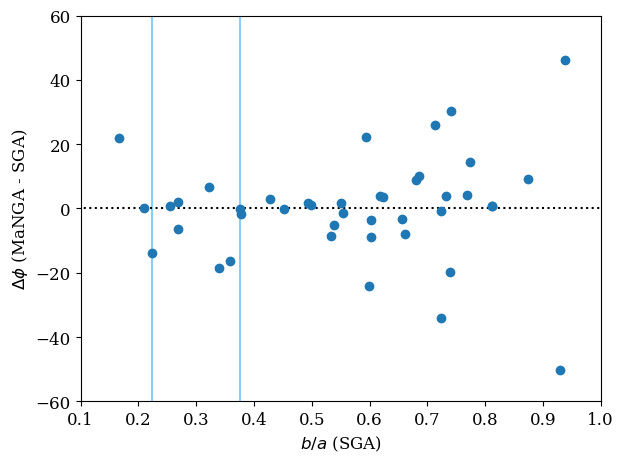

In [28]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['BA'], 
             dphi, 
             yerr=SGA_MaNGA['phi_err_map'], 
             fmt='o', 
             ecolor='lightskyblue')

plt.hlines(0, 0, 1, linestyles='dotted', colors='k')

plt.xlim([0.1, 1])
plt.ylim([-60, 60])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi$ (MaNGA - SGA)');

## 3) Compute $V(R')$ based on the MaNGA fit

In [29]:
Vp = rot_fit_BB(Rp.data, [SGA_MaNGA['Vmax'], SGA_MaNGA['Rturn'], SGA_MaNGA['alpha']])

/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: invalid value encountered in true_divide
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


## 4) Compute V(R) based on the MaNGA fit

In [30]:
V = rot_fit_BB(R.data, [SGA_MaNGA['Vmax'], SGA_MaNGA['Rturn'], SGA_MaNGA['alpha']])

## 5) Compute $\Delta V = V(R') - V(R)$

In [31]:
dV = Vp - V

SGA_MaNGA['delta_V'] = dV

dV_avg = np.nanmean(dV)
dV_std = np.nanstd(dV)

print('Number of galaxies:', np.sum(np.isfinite(dV)))
print(f'Delta V = {dV_avg:.0f} +/- {dV_std:.1f}')

Number of galaxies: 41
Delta V = 24 +/- 64.7


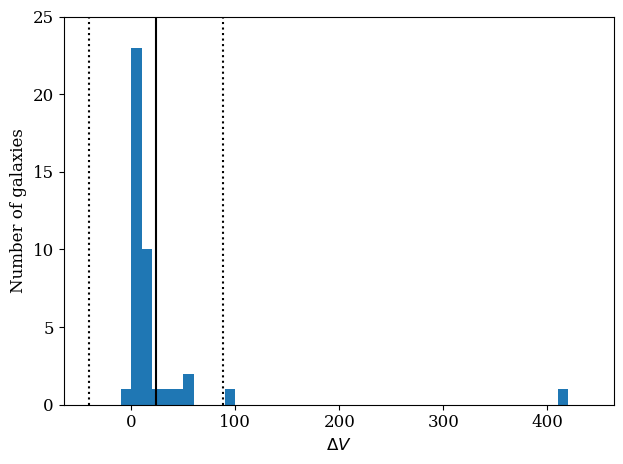

In [33]:
plt.figure(tight_layout=True)

plt.hist(dV, bins=np.arange(-10, 450, 10))

plt.vlines([dV_avg, dV_avg - dV_std, dV_avg + dV_std], 0, 35, linestyles=['solid', 'dotted', 'dotted'], colors='k')

plt.ylim([0, 25])

plt.xlabel('$\Delta V$')
plt.ylabel('Number of galaxies');

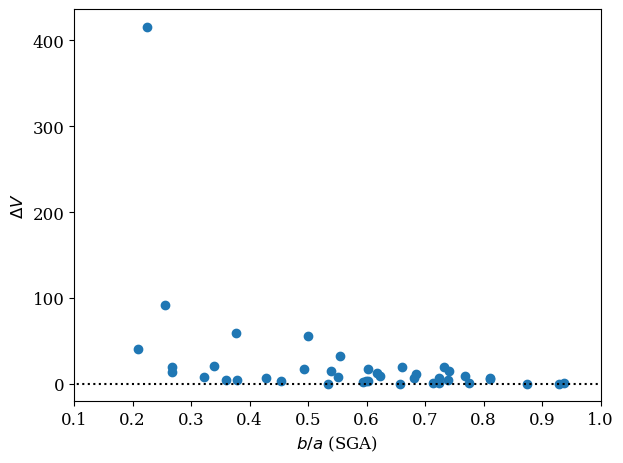

In [34]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'], dV, 'o')

plt.hlines(0, 0, 1, linestyles='dotted', colors='k')

plt.xlim([0.1, 1])
#plt.ylim([-60, 60])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta V$');

In [35]:
SGA_MaNGA[np.isfinite(SGA_MaNGA['phi_map'])].show_in_notebook()

idx,MaNGA_plate,MaNGA_IFU,sga_id,BA,PA,plateifu,z_NSA,phi_map,phi_err_map,Vmax,Vmax_err,Rturn,Rturn_err,alpha,alpha_err,R26,delta_phi,delta_V,R,R_prime,cosi2
,,,,,,,,,,,,,,,,,,,kpc,kpc,
0,7968,3702,97758,0.3215293288230896,159.22218322753906,7968-3702,0.035792,345.879504,0.197909,96.526484,2.351941,1.820115,0.051089,1.575715,0.117749,0.38318246603012085,6.657320772460935,7.5146676787672675,3.9468657701810232,6.709089918027707,0.06602198884731925
1,8481,12705,810971,0.268082857131958,56.5462760925293,8481-12705,0.042946,50.108213,0.036689,215.757148,0.949955,4.960199,0.018174,2.916999,0.012576,0.40546661615371704,-6.438063092529298,18.947599596107636,5.011163634711799,6.520350023174393,0.03319626905003521
2,8484,3701,302062,0.6225041747093201,119.090087890625,8484-3701,0.033016,122.814208,0.051938,164.576998,0.89449,3.28499,0.020521,1.573844,0.014198,0.5241257548332214,3.7241201093749936,8.513523078605289,4.979901126258565,6.166678586523152,0.36199109117763717
3,8547,6102,925354,0.6025776267051697,146.05860900878906,8547-6102,0.030466,317.219445,0.041724,279.927514,1.097489,3.318422,0.013883,1.377079,0.009599,0.5400673747062683,-8.839164008789055,16.650820074199856,4.735045360861341,5.993502633486383,0.33656228771420293
4,8547,6103,171058,0.5511276125907898,3.9989326000213623,8547-6103,0.042394,365.726051,0.04463,148.344131,0.390185,1.62815,0.010028,2.094651,0.029161,0.3225766718387604,1.7271183999786217,7.152879159591663,3.9354836600295915,7.442059650261804,0.274730880583358
5,8555,12703,127268,0.2092917561531067,143.2239532470703,8555-12703,0.058449,323.520149,0.032823,265.405389,0.624707,4.577633,0.02414,1.750407,0.016783,0.47411099076271057,0.296195752929691,40.76429769855105,7.974764578451687,37.76102269182095,0.003961499160053609
6,8555,1902,575284,0.6609105467796326,106.39098358154297,8555-1902,0.031485,98.424392,0.224693,249.074119,12.795792,0.90268,0.048537,0.933194,0.07533,0.2790890336036682,-7.966591581542971,19.369250076396384,2.5287577714158083,3.9186897001309338,0.41333619879640926
7,8555,9102,1285122,0.7685890793800354,107.45079040527344,8555-9102,0.045967,111.597452,0.059325,274.302682,2.498474,0.74925,0.019146,0.727318,0.010616,0.2687503695487976,4.146661594726567,9.351671770479584,3.5551341391967166,4.396908297390352,0.5736762218148441
8,8600,1901,186915,0.7746372222900391,129.28488159179688,8600-1901,0.025213,143.614839,0.032893,112.082824,0.196481,1.28017,0.002393,6.912017,0.09759,0.29188093543052673,14.329957408203114,0.4095516045180716,2.1178296016548126,2.751450343016014,0.5833987772471119
